In [1]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds


2023-01-15 17:16:28.459998: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [27]:
import tensorflow.experimental.numpy as tnp

In [2]:
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
import tensorflow_addons as tfa

In [3]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()        

In [4]:
# image cropped, rescaled to 48x48 already

FER_PATH="FER2013/ALL" 
FER_PATH= pathlib.Path(FER_PATH)
image_count = len(list(FER_PATH.glob('*/*.png')))
#print(image_count)

In [5]:
angry = list(FER_PATH.glob('angry/*'))
neutral = list(FER_PATH.glob('neutral/*'))
disgust = list(FER_PATH.glob('disgust/*'))
fear = list(FER_PATH.glob('fear/*'))
happy = list(FER_PATH.glob('happy/*'))
sad = list(FER_PATH.glob('sad/*'))
surprise = list(FER_PATH.glob('surprise/*'))
#PIL.Image.open(str(happy[0]))


In [6]:
batch_size=100 #test
img_height = 48
img_width = 48

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
FER_PATH,
labels='inferred',
label_mode='int',
validation_split=0.1,
subset="training",
seed=100,
image_size=(img_height, img_width),
batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
FER_PATH,
labels='inferred',
label_mode='int',
validation_split=0.1,
subset="validation",
seed=100,
image_size=(img_height, img_width),
batch_size=batch_size)


Found 35887 files belonging to 7 classes.
Using 32299 files for training.


2023-01-15 17:16:54.791423: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 35887 files belonging to 7 classes.
Using 3588 files for validation.


In [35]:
class_no = 7

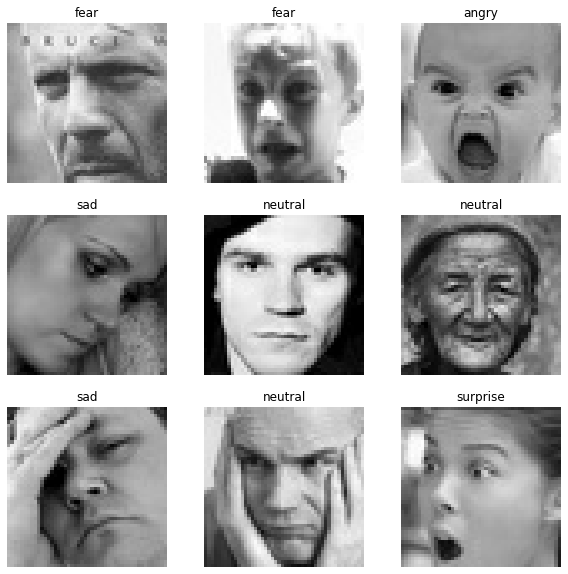

In [12]:
"""
plt.figure(figsize=(10, 10)) #first 9 image with class
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
        
"""

In [8]:
for image_batch, labels_batch in train_ds:
    input_shape = image_batch.shape
    label_shape = labels_batch.shape
    print(input_shape)
    #print(label_shape )
    break 

(100, 48, 48, 3)


In [9]:
image_batch = image_batch.reshape(batch_size, img_height, img_width, 3)
image_batch = image_batch.astype('float32')
image_batch = image_batch/255

In [28]:
def rotation(image,angle):
    rot_image = tfa.image.rotate(image, angle, interpolation = 'nearest')

    return rot_image 


def rotation_list(image):
    image_list=[]
    
    disgust_img_no=[]
    for i in range(len(labels_batch)):
        if labels_batch[i] == 1:
            disgust_img_no+=[i]
  
    for index in disgust_img_no:
        
        if np.array_equiv(tnp.array(image),tnp.array(image_batch[index])): 
            angles2_rad = []
            for i in range(1,11):#5 degrees of rotation at a step of 0.5 degrees
                angles2_rad +=[0.5*i* np.pi / 180] 
                image_list +=[rotation(image,angles2_rad[i-1])]
            break

        else: 

            angles1_rad = []

            for i in range(1,51):#5 degrees of rotation at a step of 0.1 degrees
                angles1_rad +=[0.1*i* np.pi / 180]
                image_list +=[rotation(image,angles1_rad[i-1])]
            break
            
    return image_list


In [23]:
if np.array_equiv(np.array(image_batch[14]),np.array(image_batch[14])):
    print(0)

0


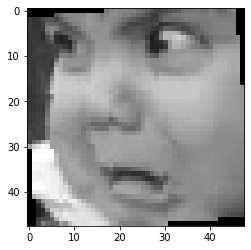

In [12]:
plt.imshow(rotation_list(image_batch[14])[9])


In [29]:
#len(rotation_list(image_batch[14]))

10

In [30]:
aut_train_ds = train_ds.map(lambda x, y: (rotation_list(x), y))
aut_test_ds = test_ds.map(lambda x, y: (rotation_list(x), y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [31]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE) #no rotation
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


aut_train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
aut_test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [38]:
#FIRST PROPOSED MODEL
#-------------------
model = keras.Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1.0 / 255)) #normalization

#--convolutional layer x3---
model.add(tf.keras.layers.Conv2D(6, kernel_size=(3, 3),padding='same',  activation='relu', input_shape=(image_batch.shape[1], image_batch.shape[2], 3) ))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(image_batch.shape[1], image_batch.shape[2], 3) ))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=(image_batch.shape[1], image_batch.shape[2], 3) ))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
#--Fully Connected Layers x2---

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256,activation=None))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(128,activation=None))
model.add(tf.keras.layers.Dropout(0.5))

#--

model.add(tf.keras.layers.Dense(class_no, activation='softmax'))


#-------------------

In [41]:
#model.build(input_shape)
#model.summary()

In [42]:
from tensorflow.keras import regularizers

In [75]:
#Second PROPOSED model_2nd
#-------------------
model_2nd = keras.Sequential()

#--convolutional layer x3---
model_2nd.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3),padding='same',  activation='relu', input_shape=(image_batch.shape[1], image_batch.shape[2], 3) ))
model_2nd.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu',input_shape=(image_batch.shape[1], image_batch.shape[2], 3) ))
model_2nd.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model_2nd.add(tf.keras.layers.BatchNormalization())

model_2nd.add(tf.keras.layers.Conv2D(128, kernel_size=(3, 3),padding='same',  activation='relu', input_shape=(image_batch.shape[1], image_batch.shape[2], 3) ))
model_2nd.add(tf.keras.layers.Conv2D(128, kernel_size=(3, 3),padding='same', activation='relu',input_shape=(image_batch.shape[1], image_batch.shape[2], 3) ))
model_2nd.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model_2nd.add(tf.keras.layers.BatchNormalization())

model_2nd.add(tf.keras.layers.Conv2D(256, kernel_size=(3, 3),padding='same',  activation='relu', input_shape=(image_batch.shape[1], image_batch.shape[2], 3) ))
model_2nd.add(tf.keras.layers.Conv2D(256, kernel_size=(3, 3),  activation='relu',input_shape=(image_batch.shape[1], image_batch.shape[2], 3) ))
model_2nd.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model_2nd.add(tf.keras.layers.BatchNormalization())


#--Fully Connected Layers x2---

model_2nd.add(tf.keras.layers.Flatten())
model_2nd.add(tf.keras.layers.Dense(256,activation=None))
model_2nd.add(tf.keras.layers.Dropout(0.5))

model_2nd.add(tf.keras.layers.Dense(128,activation=None))
model_2nd.add(tf.keras.layers.Dropout(0.5))

#--

model_2nd.add(tf.keras.layers.Dense(class_no, activation='softmax', kernel_regularizer=regularizers.L1(0.01))) #regularizer


#-------------------

In [76]:
model_2nd.build(input_shape)
model_2nd.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_95 (Conv2D)          (None, 48, 48, 64)        1792      
                                                                 
 conv2d_96 (Conv2D)          (None, 48, 48, 64)        36928     
                                                                 
 max_pooling2d_57 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 batch_normalization_56 (Bat  (None, 24, 24, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_97 (Conv2D)          (None, 24, 24, 128)       73856     
                                                                 
 conv2d_98 (Conv2D)          (None, 24, 24, 128)     

In [29]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [77]:
model_2nd.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [79]:
#history= model.fit(train_ds, batch_size=7, epochs=100,verbose=1,validation_data = test_ds)

history= model_2nd.fit(aut_train_ds, batch_size=7, epochs=30,verbose=1,validation_data = aut_test_ds)

Epoch 1/30
323/323 [==============================] - 340s 1s/step - loss: 3.9104 - accuracy: 0.2619 - val_loss: 2.1161 - val_accuracy: 0.3534
Epoch 2/30
323/323 [==============================] - 333s 1s/step - loss: 1.9520 - accuracy: 0.3960 - val_loss: 1.6105 - val_accuracy: 0.4816
Epoch 3/30
323/323 [==============================] - 333s 1s/step - loss: 1.4777 - accuracy: 0.4963 - val_loss: 1.5119 - val_accuracy: 0.4763
Epoch 4/30
323/323 [==============================] - 333s 1s/step - loss: 1.2873 - accuracy: 0.5477 - val_loss: 1.5472 - val_accuracy: 0.4774
Epoch 5/30
323/323 [==============================] - 332s 1s/step - loss: 1.1858 - accuracy: 0.5814 - val_loss: 1.2952 - val_accuracy: 0.5446
Epoch 6/30
323/323 [==============================] - 332s 1s/step - loss: 1.1101 - accuracy: 0.6099 - val_loss: 1.3667 - val_accuracy: 0.5103
Epoch 7/30
323/323 [==============================] - 332s 1s/step - loss: 1.0481 - accuracy: 0.6327 - val_loss: 1.2501 - val_accuracy: 0.5700

KeyboardInterrupt: 